# 使用 ToolNode 调用 tools

`ToolNode`是一个 `Runnable` 类型，以LangGraph的state（包含消息历史列表）作为输入，并把工具结果封装为最新state作为输出。

In [1]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

In [2]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."


@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "nyc, sf"

In [3]:
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

## 手动调用工具

ToolNode operates on graph state with a list of messages. 
It expects the last message in the list to be an AIMessage with tool_calls parameter.

In [5]:
# 手动调用工具方法
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id')]}

## 并行调用多个工具

You can also do parallel tool calling using ToolNode if you pass multiple tool calls to AIMessage's tool_calls parameter:

In [7]:
# 并行调用工具
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_coolest_cities",
            "args": {},
            "id": "tool_call_id_1",
            "type": "tool_call",
        },
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
    ],
)

tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='nyc, sf', name='get_coolest_cities', tool_call_id='tool_call_id_1'),
  ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id_2')]}

## Using with chat models


In [13]:
from typing import Literal

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


model_with_tools = ChatOpenAI(temperature=0).bind_tools(tools)

In [16]:
model_with_tools.invoke("what's the weather in sf?").tool_calls

[{'name': 'get_weather',
  'args': {'location': 'San Francisco'},
  'id': 'call_4xk5lQOwqJz5x8jOuPSB2M5h',
  'type': 'tool_call'}]

In [17]:
tool_node.invoke({"messages": [model_with_tools.invoke("what's the weather in sf?")]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='call_q7AGoMJPCgKB7daqrMwf4Gk4')]}

## ReAct Agent

In [19]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

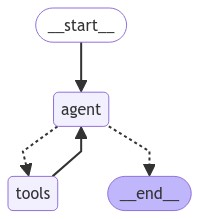

In [20]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "what's the weather in sf?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in sf?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_aFqptjAQUWe21FY5QjiwzsbN)
 Call ID: call_aFqptjAQUWe21FY5QjiwzsbN
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

The weather in San Francisco is currently 60 degrees and foggy.


In [22]:
# 同时使用多个工具调用。example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "what's the weather in the coolest cities?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in the coolest cities?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_aILnuzuVaEACjKD5A8I6wJdC)
 Call ID: call_aILnuzuVaEACjKD5A8I6wJdC
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

nyc, sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_OtDIRy4Alw5IEjsSmiiQvYzC)
 Call ID: call_OtDIRy4Alw5IEjsSmiiQvYzC
  Args:
    location: nyc
  get_weather (call_NhQYPJFMdAtLKTOMPsl1yliz)
 Call ID: call_NhQYPJFMdAtLKTOMPsl1yliz
  Args:
    location: sf
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

The weather in the coolest cities is as fo